In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

In [2]:
#!pip install pytorch-lightning


In [3]:
#!pip install datasets

In [4]:
#!pip install absl-py nltk rouge-score


In [5]:
#!pip install --upgrade pytorch-lightning


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [6]:
df = pd.read_csv('ext_train_data.csv')

In [7]:
print(df.keys())

Index(['medical_history', 'ground_truth_summary'], dtype='object')


In [10]:
example_data = df[:50]
text_len = []
summary_len=[]
for i in range(len(example_data)):
    text_example = example_data['medical_history'].iloc[i]
    text_example = text_example.replace('\n','')
    text_words = text_example.split()
    text_len.append(len(text_words))
    summary_example = example_data['ground_truth_summary'].iloc[i]
    summary_example = summary_example.replace('\n','')
    summary_words = summary_example.split()
    summary_len.append(len(summary_words))

<function matplotlib.pyplot.show(close=None, block=None)>

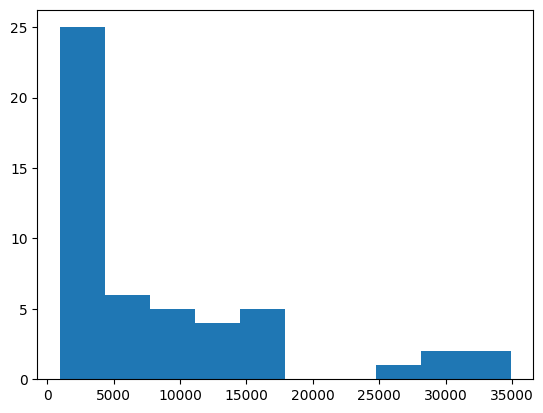

In [11]:
plt.hist(text_len)
plt.show

In [44]:
class abstractive_summ(Dataset):
    def __init__(self, tokenizer, file_path, num_samples, input_length, output_length, print_text=False):         
        self.dataset =  pd.read_csv(file_path)
        if num_samples:
            self.dataset = self.dataset[:num_samples]
        self.input_length = input_length
        self.tokenizer = tokenizer
        self.output_length = output_length
        self.print_text = print_text
  
    def __len__(self):
        return self.dataset.shape[0]
    
    def clean_text(self, text):
        text = text.replace('\n','')
        text = text.replace('``', '')
        text = text.replace('"', '')
        
        return text
    
    
    def convert_to_features(self, example_batch):
        # Tokenize contexts and questions (as pairs of inputs)
        
        if self.print_text:
            print("Input Text: ", self.clean_text(example_batch['medical_history']))
#         input_ = self.clean_text(example_batch['text']) + " </s>"
#         target_ = self.clean_text(example_batch['headline']) + " </s>"
        
        input_ = self.clean_text(example_batch['medical_history'])
        target_ = self.clean_text(example_batch['ground_truth_summary'])
        
        source = self.tokenizer.batch_encode_plus([input_], max_length=self.input_length, 
                                                     padding='max_length', truncation=True, return_tensors="pt")
        
        targets = self.tokenizer.batch_encode_plus([target_], max_length=self.output_length, 
                                                     padding='max_length', truncation=True, return_tensors="pt")
    
       
        return source, targets
  
    def __getitem__(self, index):
        source, targets = self.convert_to_features(self.dataset.iloc[index])
        
        source_ids = source["input_ids"].squeeze()
        target_ids = targets["input_ids"].squeeze()

        src_mask    = source["attention_mask"].squeeze()
        target_mask = targets["attention_mask"].squeeze()

        return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}
        
    

In [41]:
def get_dataset(tokenizer, type_path, num_samples, args):
    file_path = f"{type_path}_data.csv"  # train_data.csv, validation_data.csv, test_data.csv
    dataset = abstractive_summ(tokenizer=tokenizer, file_path=file_path, num_samples=num_samples, input_length=args.max_input_length, output_length=args.max_output_length)
    return dataset


In [30]:
import torch
from torch.utils.data import DataLoader
from transformers import T5ForConditionalGeneration, T5Tokenizer, AdamW, get_linear_schedule_with_warmup
import pytorch_lightning as pl
from datasets import load_metric
import time
import numpy as np

class T5FineTuner(pl.LightningModule):
    def __init__(self, hparams):
        super(T5FineTuner, self).__init__()
        self.save_hyperparameters(hparams)
        self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
        self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)
        self.rouge_metric = load_metric('rouge') 
        
        if self.hparams.freeze_embeds:
            self.freeze_embeds()
        if self.hparams.freeze_encoder:
            self.freeze_params(self.model.get_encoder())
            assert_all_frozen(self.model.get_encoder())
            
        self.n_obs = {
            "train": self.hparams.n_train,
            "validation": self.hparams.n_val,
            "test": self.hparams.n_test
        }
        
    def freeze_params(self, model):
        for par in model.parameters():
            par.requires_grad = False
            
    def freeze_embeds(self):
        try:
            self.freeze_params(self.model.shared)
            for d in [self.model.encoder, self.model.decoder]:
                self.freeze_params(d.embed_tokens)
        except AttributeError:
            self.freeze_params(self.model.shared)
            for d in [self.model.encoder, self.model.decoder]:
                self.freeze_params(d.embed_tokens)
    
    def forward(self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None):
        return self.model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            labels=lm_labels,
        )

    def _step(self, batch):
        lm_labels = batch["target_ids"]
        lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

        outputs = self(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            lm_labels=lm_labels,
            decoder_attention_mask=batch['target_mask']
        )

        loss = outputs.loss

        return loss

    def training_step(self, batch, batch_idx):
        loss = self._step(batch)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
  
    def validation_step(self, batch, batch_idx):
        loss = self._step(batch)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=self.hparams.total_steps
        )
        return [optimizer], [{'scheduler': scheduler, 'interval': 'step'}]

    def train_dataloader(self):   
        train_dataset = get_dataset(self.tokenizer, 'train', self.n_obs['train'], self.hparams)
        return DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        validation_dataset = get_dataset(self.tokenizer, 'validation', self.n_obs['validation'], self.hparams)
        return DataLoader(validation_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)

    def test_dataloader(self):
        test_dataset = get_dataset(self.tokenizer, 'test', self.n_obs['test'], self.hparams)
        return DataLoader(test_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)


In [32]:
from argparse import Namespace

args_dict = {
    'model_name_or_path': 't5-large',
    'tokenizer_name_or_path': 't5-large',
    'max_input_length': 512,
    'max_output_length': 512,
    'freeze_encoder': False,
    'freeze_embeds': False,
    'learning_rate': 1e-4,
    'weight_decay': 0.0,
    'adam_epsilon': 1e-8,
    'warmup_steps': 0,
    'train_batch_size': 16,
    'eval_batch_size': 16,
    'num_train_epochs': 3,
    'n_train': 2000,  #training samples
    'n_val': 400,     # validation samples
    'n_test': 400,    #test samples
    'gradient_accumulation_steps': 16,
    'n_gpu': 1,
    'early_stop_callback': False,
    'fp_16': False,  
    'opt_level': 'O1', 
    'max_grad_norm': 1.0,
    'seed': 42,
    #'total_steps': (n_train / train_batch_size / gradient_accumulation_steps) * num_train_epochs
    'total_steps': 23
}
args = Namespace(**args_dict)


In [34]:
model = T5FineTuner(args)

In [36]:
from pytorch_lightning import Trainer
trainer = Trainer(
    max_epochs=args.num_train_epochs
)


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [45]:
trainer.fit(model)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/goodone/.local/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 60.5 M
-----------------------------------------------------
60.5 M    Trainable params
0         Non-trainable params
60.5 M    Total params
242.026   Total estimated model params size (MB)


Sanity Checking: |                                         | 0/? [00:00<?, ?it/s]

Training: |                                                | 0/? [00:00<?, ?it/s]

Validation: |                                              | 0/? [00:00<?, ?it/s]

Validation: |                                              | 0/? [00:00<?, ?it/s]

Validation: |                                              | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [59]:
model.eval()  # set the model to evaluation mode

# Function to generate summary
def generate_summary(text, max_length=700):
    # Tokenize the input text
    inputs =  T5Tokenizer.from_pretrained('t5-small').encode("summarize: " + text, return_tensors="pt", max_length=512, truncation=True)

    # Generate summary
    summary_ids = model.model.generate(inputs, max_length=max_length, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    
    # Decode and return the summary
    return T5Tokenizer.from_pretrained('t5-small').decode(summary_ids[0], skip_special_tokens=True)


In [78]:
test_example = pd.read_csv('test_data.csv')
input_text = test_example['medical_history'].iloc[12]
summary = generate_summary(input_text)
print(summary)

the patient was taken to the cardiac catheterization laboratory and underwent a cardiac catheterization, which revealed a left ventricular ejection fraction of 55% and a left main coronary artery occlusion of 90%. he underwent coronary artery bypass grafting times four with a left internal mammary artery graft to the left anterior descending artery, a saphenous vein graft to the left anterior descending artery, a saphenous vein graft


In [79]:
print(test_example['ground_truth_summary'].iloc[12])

This is a 78-year-old gentleman
who presented to the cardiac catheterization laboratory after
being referred for approximately three episodes of chest pain
while walking followed by a positive exercise tolerance test.
